In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Homework 1

Mounted at /gdrive
/gdrive/My Drive/Homework 1


### Import libraries

In [2]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging
import platform

import random
random.seed(seed)

In [3]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import mixed_precision
from tensorflow.keras import applications
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [4]:
# Import other libraries
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
from PIL import Image
from sklearn.model_selection import KFold
import zipfile

In [5]:
# Setup Mixed Precision

# Detect TPY
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
except ValueError:
  tpu = None

if tpu:
  policyConfig = 'mixed_bfloat16'
else:
  policyConfig = 'mixed_float16'

policy = tf.keras.mixed_precision.Policy(policyConfig)

tf.keras.mixed_precision.set_global_policy(policy)

### Load and process the (augmented) dataset

In [6]:
file_path = 'augmented_data.npz'
loaded_data = np.load(file_path, allow_pickle = True)

# Access the 'data' and 'labels' arrays
X = loaded_data['data']
labels = loaded_data['labels']

print(len(X))
print(len(labels))

X = X.astype('float32') / 255

healthy = []
unhealthy = []

# Iterate through the images to separate them into the proper set
for i, image in enumerate(X):
    if labels[i] == 'unhealthy':
        unhealthy.append(image)
    else:
        healthy.append(image)

print(len(healthy))
print(len(unhealthy))

label_dict = {'healthy': 0, 'unhealthy': 1}
y = np.array([label_dict[label] for label in labels])

12500
12500
6210
6290


In [20]:
# Codifica delle etichette 'healthy' e 'unhealthy' in numeri
label_dict = {'healthy': 0, 'unhealthy': 1}
y = np.array([label_dict[label] for label in labels]) # 0 è [1,0]

# Convert labels to one-hot encoding format
y = tfk.utils.to_categorical(y,2)

# Split data into train_val and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, random_state=seed, test_size=0.3, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, random_state=seed, test_size=0.5, stratify=y_temp)


# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

# Print shapes of the datasets
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")


X_train shape: (8750, 96, 96, 3), y_train shape: (8750, 2)
X_val shape: (1875, 96, 96, 3), y_val shape: (1875, 2)


In [21]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Reshape arrays if necessary (replace (96, 96, 3) with the actual shape of your images)
X_train = X_train.reshape((len(X_train), -1))
X_val = X_val.reshape((len(X_val), -1))

# Apply SMOTE to the training set
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

#Apply SMOTE to the training val
X_val, y_val = smote.fit_resample(X_val, y_val)

# Reshape arrays back to the original shape
X_train = X_train.reshape((len(X_train), 96, 96, 3))
X_val = X_val.reshape((len(X_val), 96, 96, 3))

# Convert labels to one-hot encoding format
y_train = tfk.utils.to_categorical(y_train, 2)
y_val = tfk.utils.to_categorical(y_val, 2)

In [22]:
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

X_train shape: (8806, 96, 96, 3), y_train shape: (8806, 2)
X_val shape: (1886, 96, 96, 3), y_val shape: (1886, 2)


In [ ]:
# Define input shape, output shape, batch size, and number of epochs
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 32
epochs = 100

img_height = 96
img_width = 96

# Print input shape, batch size, and number of epochs
print(f"Input Shape: {input_shape}, Output Shape: {output_shape}, Batch Size: {batch_size}, Epochs: {epochs}")

Input Shape: (96, 96, 3), Output Shape: (2,), Batch Size: 32, Epochs: 100


### Model

In [ ]:
callbacks = [
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True, mode='auto'),
]

In [ ]:
# Macs with Apple Silicon suffer performance penalties when using the modern Adam optimizer
# Detect system specs and select the appropriate optimizer

if platform.system() == "Darwin" and platform.processor() == "arm":
    optimizer = tf.keras.optimizers.legacy.Adam()
else:
    optimizer = tf.keras.optimizers.Adam()

9406464/9406464 [==============================] - 0s 0us/step


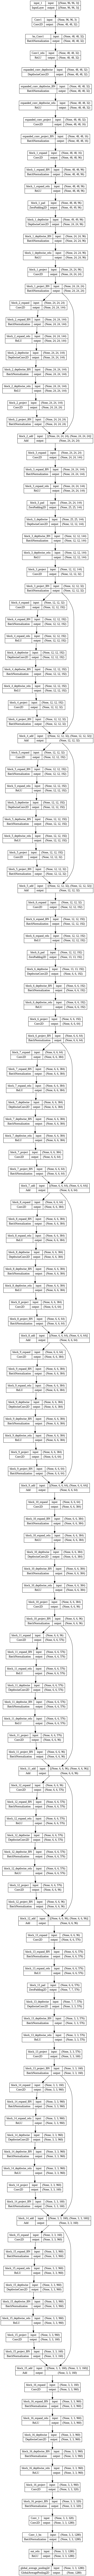

In [ ]:
mobile = tfk.applications.MobileNetV2(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
)
tfk.utils.plot_model(mobile, show_shapes=True)



In [ ]:
from keras.src import layers
# Use the supernet as feature extractor, i.e. freeze all its weigths
mobile.trainable = False

# Create an input layer with shape (96, 96, 3)
inputs = tfk.Input(shape=(96, 96, 3))

# Connect MobileNetV2 to the input
x = mobile(inputs)

#Flatten the output of the EfficientNetBO

# Add a Dense layer with 2 units and softmax activation as the classifier
outputs = tfkl.Dense(2, activation='softmax')(x)  # Modifica del numero di neuroni

# Create a Model connecting input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

if platform.system() == "Darwin" and platform.processor() == "arm":
    optimizer = tf.keras.optimizers.legacy.Adam()
else:
    optimizer = tf.keras.optimizers.Adam()

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
tl_model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=optimizer, metrics=['accuracy'])

# Display model summary
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 mobilenetv2_1.00_96 (Funct  (None, 1280)              2257984   
 ional)                                                          
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


### Train the model

In [ ]:
tl_history = tl_model.fit(
    x=preprocess_input(X_train * 255),
    y=y_train,
    batch_size=128,
    epochs=2000,
    validation_data=(preprocess_input(X_val * 255), y_val),
    callbacks=[tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=200, restore_best_weights=True)]
).history

Epoch 1/2000
74/74 [==============================] - 24s 113ms/step - loss: 0.5525 - accuracy: 0.7320 - val_loss: 0.4837 - val_accuracy: 0.7838
Epoch 2/2000
74/74 [==============================] - 4s 48ms/step - loss: 0.4511 - accuracy: 0.7973 - val_loss: 0.4466 - val_accuracy: 0.8007
Epoch 3/2000
74/74 [==============================] - 4s 51ms/step - loss: 0.4206 - accuracy: 0.8130 - val_loss: 0.4370 - val_accuracy: 0.8042
Epoch 4/2000
74/74 [==============================] - 5s 62ms/step - loss: 0.4010 - accuracy: 0.8239 - val_loss: 0.4193 - val_accuracy: 0.8171
Epoch 5/2000
74/74 [==============================] - 4s 53ms/step - loss: 0.3854 - accuracy: 0.8309 - val_loss: 0.4101 - val_accuracy: 0.8260
Epoch 6/2000
74/74 [==============================] - 4s 48ms/step - loss: 0.3745 - accuracy: 0.8388 - val_loss: 0.4037 - val_accuracy: 0.8265
Epoch 7/2000
74/74 [==============================] - 4s 52ms/step - loss: 0.3645 - accuracy: 0.8439 - val_loss: 0.3995 - val_accuracy: 0.83

In [ ]:
# Save the best model
tl_model.save('model_15-11-23')

##Fine-Tuning

In [ ]:
#Re-load the model after transfer learning
ft_model = tfk.models.load_model('model_15-11-23')
ft_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 mobilenetv2_1.00_96 (Funct  (None, 1280)              2257984   
 ional)                                                          
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [ ]:
for i, layer in enumerate(ft_model.layers):
    print(i, layer.name, layer.trainable)

0 input_2 True
1 mobilenetv2_1.00_96 False
2 dense True


In [ ]:
# Set all MobileNetV2 layers as trainable
ft_model.get_layer('mobilenetv2_1.00_96').trainable = True
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_96').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 Conv1 True
2 bn_Conv1 True
3 Conv1_relu True
4 expanded_conv_depthwise True
5 expanded_conv_depthwise_BN True
6 expanded_conv_depthwise_relu True
7 expanded_conv_project True
8 expanded_conv_project_BN True
9 block_1_expand True
10 block_1_expand_BN True
11 block_1_expand_relu True
12 block_1_pad True
13 block_1_depthwise True
14 block_1_depthwise_BN True
15 block_1_depthwise_relu True
16 block_1_project True
17 block_1_project_BN True
18 block_2_expand True
19 block_2_expand_BN True
20 block_2_expand_relu True
21 block_2_depthwise True
22 block_2_depthwise_BN True
23 block_2_depthwise_relu True
24 block_2_project True
25 block_2_project_BN True
26 block_2_add True
27 block_3_expand True
28 block_3_expand_BN True
29 block_3_expand_relu True
30 block_3_pad True
31 block_3_depthwise True
32 block_3_depthwise_BN True
33 block_3_depthwise_relu True
34 block_3_project True
35 block_3_project_BN True
36 block_4_expand True
37 block_4_expand_BN True
38 block_4_expand_relu Tru

In [ ]:
# Freeze first N layers, e.g., until the 133rd one
N = 133
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_96').layers[:N]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_96').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

0 input_1 False
1 Conv1 False
2 bn_Conv1 False
3 Conv1_relu False
4 expanded_conv_depthwise False
5 expanded_conv_depthwise_BN False
6 expanded_conv_depthwise_relu False
7 expanded_conv_project False
8 expanded_conv_project_BN False
9 block_1_expand False
10 block_1_expand_BN False
11 block_1_expand_relu False
12 block_1_pad False
13 block_1_depthwise False
14 block_1_depthwise_BN False
15 block_1_depthwise_relu False
16 block_1_project False
17 block_1_project_BN False
18 block_2_expand False
19 block_2_expand_BN False
20 block_2_expand_relu False
21 block_2_depthwise False
22 block_2_depthwise_BN False
23 block_2_depthwise_relu False
24 block_2_project False
25 block_2_project_BN False
26 block_2_add False
27 block_3_expand False
28 block_3_expand_BN False
29 block_3_expand_relu False
30 block_3_pad False
31 block_3_depthwise False
32 block_3_depthwise_BN False
33 block_3_depthwise_relu False
34 block_3_project False
35 block_3_project_BN False
36 block_4_expand False
37 block_4_expa

In [ ]:
# Compile the model
ft_model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics='accuracy')

In [ ]:
# Fine-tune the model
ft_history = ft_model.fit(
    x = preprocess_input(X_train*255), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

Epoch 1/200
589/589 [==============================] - 22s 21ms/step - loss: 0.7231 - accuracy: 0.7299 - val_loss: 0.4264 - val_accuracy: 0.8339
Epoch 2/200
589/589 [==============================] - 9s 14ms/step - loss: 0.4982 - accuracy: 0.7987 - val_loss: 0.4436 - val_accuracy: 0.8171
Epoch 3/200
589/589 [==============================] - 10s 17ms/step - loss: 0.4029 - accuracy: 0.8347 - val_loss: 0.4241 - val_accuracy: 0.8384
Epoch 4/200
589/589 [==============================] - 8s 14ms/step - loss: 0.3434 - accuracy: 0.8562 - val_loss: 0.4143 - val_accuracy: 0.8498
Epoch 5/200
589/589 [==============================] - 10s 17ms/step - loss: 0.2937 - accuracy: 0.8759 - val_loss: 0.3731 - val_accuracy: 0.8612
Epoch 6/200
589/589 [==============================] - 11s 18ms/step - loss: 0.2529 - accuracy: 0.8957 - val_loss: 0.3558 - val_accuracy: 0.8716
Epoch 7/200
589/589 [==============================] - 9s 15ms/step - loss: 0.2172 - accuracy: 0.9116 - val_loss: 0.3429 - val_accur

In [ ]:
# Evaluate the model on the test set
test_accuracy = ft_model.evaluate(preprocess_input(X_test*255),y_test,verbose=0)[-1]
print('Test set accuracy %.4f' % test_accuracy)

Test set accuracy 0.9118


In [ ]:
# Save the best model
ft_model.save('FineTuningModel')

##Validate the model

In [ ]:
'''current_datetime = datetime.now()
formatted_datetime = current_datetime.strftime("%Y%m%d_%H%M%S")

# Create the zipfile with date and time in the name
zipfile_name = f"model_{formatted_datetime}.zip"
ft_model.save(zipfile_name)

'''


def evaluate_predictions(predictions, true_labels):
    best_accuracy = 0.0
    best_limit = 0.0

    for limit in range(100):
        predicted_labels = (predictions > (limit / 100.0)).astype(int)
        accuracy = np.sum(predicted_labels == true_labels) / len(true_labels)

        if accuracy < best_accuracy:
            continue

        best_accuracy = accuracy
        best_limit = limit / 100.0

    return best_limit, best_accuracy

def print_evaluation_results(limit_1, accuracy_1, limit_2, accuracy_2, limit_3, accuracy_3):
    print("Limit on Test Set 1:", limit_1)
    print("Accuracy on Test Set 1:", accuracy_1)
    print("Limit on Test Set 2:", limit_2)
    print("Accuracy on Test Set 2:", accuracy_2)
    print("Limit on Test Set 3:", limit_3)
    print("Accuracy on Test Set 3:", accuracy_3)

def make_final_prediction(predictions_1, predictions_2, predictions_3, true_labels):
    final_prediction = []

    for i in range(len(predictions_1)):
        healthy_prediction = predictions_1[i] + predictions_2[i] + predictions_3[i]

        if np.sum(healthy_prediction) >= 2:
            final_prediction.append([1])
        else:
            final_prediction.append([0])

    final_accuracy = np.sum(final_prediction == true_labels) / len(true_labels)
    return final_accuracy

# Make predictions on each test set
predictions_1 = ft_model.predict(X_val)
predictions_2 = rotation(ft_model.predict(X_val))
predictions_3 = flip(ft_model.predict(X_val))

true_labels = y_val

# Evaluate predictions for each test set
limit_1, accuracy_1 = evaluate_predictions(predictions_1, true_labels)
limit_2, accuracy_2 = evaluate_predictions(predictions_2, true_labels)
limit_3, accuracy_3 = evaluate_predictions(predictions_3, true_labels)

# Print evaluation results
print_evaluation_results(limit_1, accuracy_1, limit_2, accuracy_2, limit_3, accuracy_3)

# Make final prediction
final_accuracy = make_final_prediction(predictions_1, predictions_2, predictions_3, true_labels)
print("Accuracy of Final Prediction:", final_accuracy)

NameError: ignored

Predictions on Test Set 1:
[[0.8252623  0.18601589]
 [0.8618742  0.12307213]
 [0.93193305 0.10193352]
 [0.2155872  0.7987375 ]
 [0.44230443 0.5974164 ]
 [0.34105167 0.66638476]
 [0.921388   0.09073287]
 [0.7281692  0.29234704]
 [0.27679634 0.72629845]
 [0.2524936  0.78236514]]

Predictions on Test Set 2:
[[0.5689203  0.42380404]
 [0.79283166 0.18095541]
 [0.57495505 0.5154006 ]
 [0.04297906 0.94434315]
 [0.96817553 0.037745  ]
 [0.6446295  0.36361825]
 [0.987176   0.01431811]
 [0.6942877  0.44072342]
 [0.6140238  0.35787553]
 [0.04109699 0.9686783 ]]

Predictions on Test Set 3:
[[0.8252623  0.18601589]
 [0.8618742  0.12307213]
 [0.8322324  0.19207734]
 [0.26009572 0.76284844]
 [0.9930479  0.00738937]
 [0.34105167 0.66638476]
 [0.48362255 0.5103874 ]
 [0.7281692  0.29234704]
 [0.27679634 0.72629845]
 [0.09209617 0.89436567]]

Final Predictions:
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]


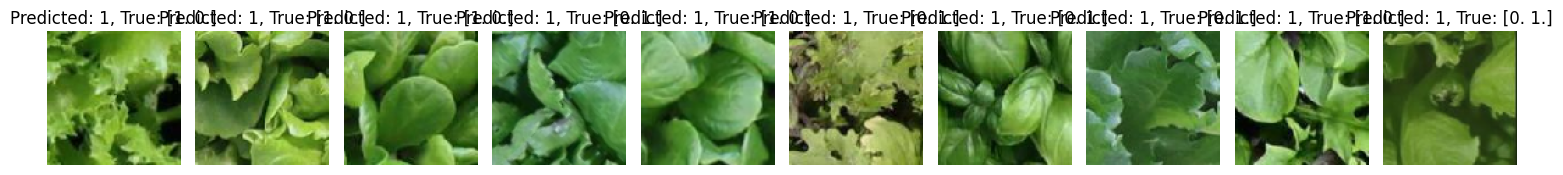

In [ ]:
# N predictions to display
N = 10

# Output the first N predictions for each set
print("Predictions on Test Set 1:")
print(predictions_1[:N])

print("\nPredictions on Test Set 2:")
print(predictions_2[:N])

print("\nPredictions on Test Set 3:")
print(predictions_3[:N])

print("\nFinal Predictions:")
print(np.array(final_prediction[:N]))

# Create subplots
fig, axes = plt.subplots(1, N, figsize=(15, 5))

for i in range(N):
    # Plot the original image from X_val
    ax = axes[i]

    # Ensure the image is properly scaled and displayed
    ax.imshow((X_val[i] * 255).astype(np.uint8))

    # Set the title with the predicted and true labels
    ax.set_title(f"Predicted: {final_prediction[i][0]}, True: {true_labels[i]}")

    ax.axis('off')

plt.tight_layout()
plt.show()


### Plot the training

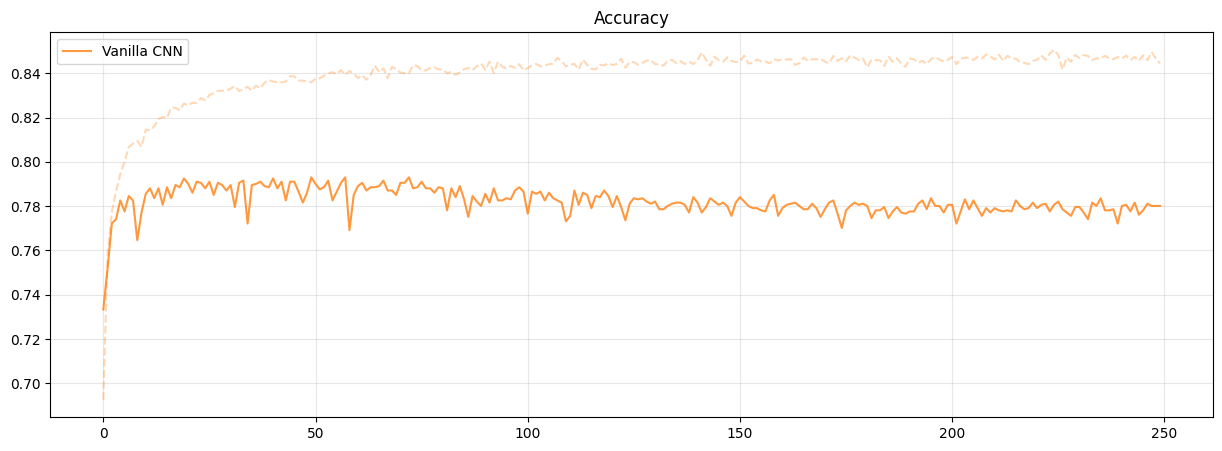

In [ ]:
# Plot the training
plt.figure(figsize=(15, 5))
plt.plot(tl_history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Vanilla CNN', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

# Save the model and create submission

In [ ]:
import os
import zipfile
from datetime import datetime
import tensorflow as tf
from os.path import basename

# Specify the name of the submission folder
submission_folder = "SubmissionModel"

# Save best epoch model
tl_model.save(os.path.join(submission_folder, "SubmissionModel"))

# Save the model.py file in the main directory
with open("model.py", "w") as model_file:
    model_file.write("""

import os
import tensorflow as tf
from tensorflow.keras import layers as tfkl

class model:
    def __init__(self, path):
        self.model = tf.keras.models.load_model(os.path.join(path, 'SubmissionModel'))

    def predict(self, X):
        # Define the RandomRotation layer
        rotation = tf.keras.Sequential([
            tfkl.RandomRotation(0.3),
        ])

        # Define the RandomFlip layer
        flip = tf.keras.Sequential([
            tfkl.RandomFlip("vertical"),
        ])

        limit = tf.constant(0.56, dtype=tf.float32)

        X_test_1 = X
        X_test_2 = rotation(X)
        X_test_3 = flip(X)

        out1 = self.model.predict(X_test_1)
        out2 = self.model.predict(X_test_2)
        out3 = self.model.predict(X_test_3)

        out1 = tf.argmax(out1, axis=-1)  # Shape [BS]
        out2 = tf.argmax(out2, axis=-1)  # Shape [BS]
        out3 = tf.argmax(out3, axis=-1)  # Shape [BS]

        out = []  # Initialize out as an empty list

        for i in range(len(out1)):
            hp = 0

            if tf.cast(out1[i], tf.float32) > limit:
                hp += 1

            if tf.cast(out2[i], tf.float32) > limit:
                hp += 1

            if tf.cast(out3[i], tf.float32) > limit:
                hp += 1

            if hp >= 2:
                out.append([1])
            else:
                out.append([0])

        out = tf.argmax(out, axis=-1)  # Shape [BS]

        return out
""")

# Create an empty metadata file in the main directory
open("metadata", "w").close()

# Get the current date and time
current_datetime = datetime.now()
formatted_datetime = current_datetime.strftime("%Y%m%d_%H%M%S")

# Create the zipfile with date and time in the name
zipfile_name = f"{submission_folder}_{formatted_datetime}.zip"

with zipfile.ZipFile(zipfile_name, 'w') as zip_file:
    # Add the entire "SubmissionModel" folder and its contents to the archive
    for foldername, subfolders, filenames in os.walk(submission_folder):
        for filename in filenames:
            file_path = os.path.join(foldername, filename)
            arcname = os.path.relpath(file_path, submission_folder)

            if (foldername in ["SubmissionModel", "SubmissionModel/model", "SubmissionModel/model/variables", "SubmissionModel/variables"]):
                continue

            # print(foldername)
            print(file_path)

            zip_file.write(file_path, arcname)

    # Add other files to the archive (model.py and metadata)
    zip_file.write("model.py", arcname="model.py")
    zip_file.write("metadata", arcname="metadata")

print(zipfile_name)


SubmissionModel/SubmissionModel/saved_model.pb
SubmissionModel/SubmissionModel/fingerprint.pb
SubmissionModel/SubmissionModel/keras_metadata.pb
SubmissionModel/SubmissionModel/variables/variables.data-00000-of-00001
SubmissionModel/SubmissionModel/variables/variables.index
SubmissionModel_20231115_174940.zip
